## Etude de modèles à utiliser pour le Projet LocalPositioningSystem

In [1]:
import os

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split

### Récupération des données

In [2]:
### COMMON ###

def enlever_extension(nom):
    return ".".join(nom.split(".")[:-1])

In [3]:
class Wifi:
    def __init__(self, BSSID, capabilities, centerFreq0, centerFreq1,
                 channelWidth, frequency, level, operatorFriendlyName, SSID,
                 timestamp, venueName):
        self.BSSID = BSSID
        self.capabilities = capabilities
        self.centerFreq0 = centerFreq0
        self.centerFreq1 = centerFreq1
        self.channelWidth = channelWidth
        self.frequency = frequency
        self.level = level
        self.operatorFriendlyName = operatorFriendlyName
        self.SSID = SSID
        self.timestamp = timestamp
        self.venueName = venueName

class Scan:
    def __init__(self, date, info, piece, lWifi):
        self.date = date
        self.info = info
        self.piece = piece
        self.lWifi = lWifi

class ScanManager:
    def __init__(self):
        self.lScan = []
        self.pieceOrder = {}
        self.pieceInverse = {}
        self.BSSIDOrder = {}
    
    def read(self, directory="./data/res/"):
        # pour chaque fichier dans le dossier
        i = 0
        j = 0
        for fname in os.listdir(directory):
            with open(directory + fname) as fichier:
                # la piece est donnée par le nom du fichier
                piece = enlever_extension(fname)
                tmp = self.pieceOrder[piece] = i
                
                self.pieceInverse[tmp] = piece
                
                piece = tmp
                i += 1
                
                # Separation des scans
                for scanData in fichier.read().split("scan")[1:]:
                    
                    scan_lines = scanData.splitlines()
                    scanDate = scan_lines[0].split(":")[1]
                    scanInfo = scan_lines[1].split(":")[1]
                    scanWifis = []

                    wifis_content = scan_lines[2:]

                    # Separation des wifis detectes sur le scan
                    wifis_list = [wifis_content[x:x+11] for x in range(0, len(wifis_content), 12)][:-1]
                    
                    for wifi_car_l in (wifis_list) :
                        BSSID = wifi_car_l[0].split("BSSID:")[1]
                        if BSSID not in self.BSSIDOrder:
                            self.BSSIDOrder[BSSID] = j
                            j += 1
                            
                        wifiBSSID = self.BSSIDOrder[BSSID]
                        cap = wifi_car_l[1].split(":")[1]
                        freq0 = int(wifi_car_l[2].split(":")[1])
                        freq1 = int(wifi_car_l[3].split(":")[1])
                        cWidth = int(wifi_car_l[4].split(":")[1])
                        freq = int(wifi_car_l[5].split(":")[1])
                        level = int(wifi_car_l[6].split(":")[1])
                        op_name = wifi_car_l[7].split(":")[1]
                        ssid = wifi_car_l[8].split(":")[1]
                        ts = int(wifi_car_l[9].split(":")[1])
                        vn = wifi_car_l[10].split(":")[1]                            
                            
                        wifi = Wifi(wifiBSSID, cap, freq0, freq1, cWidth, freq, level, op_name, ssid,ts, vn)
                        scanWifis.append(wifi)
                    scan = Scan(scanDate, scanInfo, piece, scanWifis)
                    self.lScan.append(scan)


### Correlations

In [4]:
def get_data_csv(scanMan, set_mod = True):
    dico = {}
    dico["BSSID"] = []
    # dico["capabilities"] = []
    dico["centerFreq0"] = []
    dico["centerFreq1"] = []
    dico["channelWidth"] = []
    dico["frequency"] = []
    dico["level"] = []
    dico["operatorFriendlyName"] = []
    dico["SSID"] = []
    dico["timestamp"] = []
    # dico["venueName"] = []
    dico["piece"] = []
    dico["zone_info"] = []
    dico["date"] = []
    
    i = 0
    prev_piece = scanMan.lScan[0].piece
    for scan in scanMan.lScan :
        for wifi in scan.lWifi:
            if prev_piece != scan.piece:
                prev_piece = scan.piece
                i = 0
            if set_mod == True :
                dico["piece"].append(str(scan.piece) + ":" + str(i))
            else :
                dico["piece"].append(str(scan.piece))
            dico["zone_info"].append(scan.info)
            dico["date"].append(scan.date)
            
            dico["BSSID"].append(wifi.BSSID)
            # dico["capabilities"].append(wifi.capabilities)
            dico["centerFreq0"].append(wifi.centerFreq0)
            dico["centerFreq1"].append(wifi.centerFreq1)
            dico["channelWidth"].append(wifi.channelWidth)
            dico["frequency"].append(wifi.frequency)
            dico["level"].append(wifi.level)
            dico["operatorFriendlyName"].append(wifi.operatorFriendlyName)
            dico["SSID"].append(wifi.SSID)
            dico["timestamp"].append(wifi.timestamp)
            # dico["venueName"].append(wifi.venueName)
        i += 1
    data_csv = pd.DataFrame.from_dict(dico)
    
    return data_csv
    


In [5]:
def data_organizer(scanMan, car = 'level', set_mod = True):
    
    all_data_csv = get_data_csv(scanMan, set_mod)

    data_csv = all_data_csv[ ['BSSID', 'piece', car] ]
    data_csv = data_csv.pivot_table(data_csv,
                                    index=['BSSID'],
                                    columns = ['piece'],
                                    aggfunc={car: np.mean},
                                    fill_value=0)

      
    return data_csv.astype(int)

def all_data_organizer(scanMan):
    
    all_data_csv = get_data_csv(scanMan, False)

    data_csv = all_data_csv.pivot_table(all_data_csv,
                                    index=['BSSID'],
                                    columns = ['piece'], 
                                    aggfunc={'level': np.mean,
                                             'frequency': np.mean},
                                    fill_value=0)

    return data_csv.astype(int)

def data_organizer2(scanMan, car = 'level'):
    
    all_data_csv = get_data_csv(scanMan, set_mod=False)

    data_csv = all_data_csv[ ['BSSID', 'piece', car] ]
    data_csv = data_csv.set_index(['BSSID'])
    return data_csv.astype(int)

In [6]:
scanMan = ScanManager()
scanMan.read()
all_data_csv = get_data_csv(scanMan, set_mod=False)
all_data_csv.head()

,BSSID,centerFreq0,centerFreq1,channelWidth,frequency,level,operatorFriendlyName,SSID,timestamp,piece,zone_info,date
0,0,0,0,0,2437,-57,,,467045638667,0,arrière,2021-04-16_10-10-58
1,1,0,0,0,5580,-63,,UnivToulon,467048998261,0,arrière,2021-04-16_10-10-58
2,2,0,0,0,5180,-66,,eduroam,467046319703,0,arrière,2021-04-16_10-10-58
3,3,0,0,0,5180,-68,,visiteurs,467046321254,0,arrière,2021-04-16_10-10-58
4,4,0,0,0,5180,-70,,UnivToulon,467046320828,0,arrière,2021-04-16_10-10-58


In [7]:
scanMan = ScanManager()
scanMan.read()
data_csv = data_organizer(scanMan, set_mod=False)
# data_csv['BSSID'] = int(data_csv['BSSID'].replace(":", ""),  16)

print(data_csv)

      level                                                              
piece     0  1  10  11  12 13  14  15  16 17  2   3   4  5   6   7   8  9
BSSID                                                                    
0       -51  0   0   0   0  0 -64   0 -65  0  0   0 -66  0 -68 -77 -74  0
1       -65  0   0   0   0  0 -65   0 -62  0  0   0 -83  0 -43 -60   0  0
2       -53  0   0   0   0  0 -65 -77 -63  0  0 -65 -82  0 -66 -77 -88  0
3       -53  0   0   0   0  0 -65 -76 -63  0  0 -65 -82  0 -67 -78 -89  0
4       -53  0   0   0   0  0 -65 -76 -62  0  0 -65 -82  0 -67 -77 -89  0
...     ... ..  ..  ..  .. ..  ..  ..  .. .. ..  ..  .. ..  ..  ..  .. ..
206       0  0 -68   0 -73  0   0 -68   0  0  0   0   0  0   0   0   0  0
207       0  0 -92 -61   0  0   0 -66   0  0  0   0   0  0   0   0   0  0
208       0  0   0 -80 -81  0   0 -80   0  0  0   0   0  0   0   0   0  0
209       0  0   0   0   0  0   0 -81   0  0  0   0   0  0   0   0   0  0
210       0  0   0   0   0  0   0   0 

In [8]:
all_org_data_csv = all_data_organizer(scanMan)
all_org_data_csv  

frequency                                               ... level        \
piece         0  1    10    11    12 13    14    15    16 17  ...    16 17  2   
BSSID                                                         ...               
0          2437  0     0     0     0  0  2437     0  2437  0  ...   -65  0  0   
1          5580  0     0     0     0  0  5580     0  5580  0  ...   -62  0  0   
2          5180  0     0     0     0  0  5180  5260  5180  0  ...   -63  0  0   
3          5180  0     0     0     0  0  5180  5260  5180  0  ...   -63  0  0   
4          5180  0     0     0     0  0  5180  5260  5180  0  ...   -62  0  0   
...         ... ..   ...   ...   ... ..   ...   ...   ... ..  ...   ... .. ..   
206           0  0  2462     0  2462  0     0  2462     0  0  ...     0  0  0   
207           0  0  2412  2462     0  0     0  2462     0  0  ...     0  0  0   
208           0  0     0  2437  2412  0     0  2437     0  0  ...     0  0  0   
209           0  0     0     0     0  0     0  2462     0  0  ...     0  0  0   
210           0  0     0     0     0  0     0     0  2462  0  ...   -96  0  0   

                                 
piece   3   4  5   6   7   8  9  
BSSID                            
0       0 -66  0 -68 -77 -74  0  
1       0 -83  0 -43 -60   0  0  
2     -65 -82  0 -66 -77 -88  0  
3     -65 -82  0 -67 -78 -89  0  
4     -65 -82  0 -67 -77 -89  0  
...    ..  .. ..  ..  ..  .. ..  
206     0   0  0   0   0   0  0  
207     0   0  0   0   0   0  0  
208     0   0  0   0   0   0  0  
209     0   0  0   0   0   0  0  
210     0   0  0   0   0   0  0  

[211 rows x 36 columns]

In [9]:
def model_data_analyzer(scanMan):
    model_data_csv = get_data_csv(scanMan, set_mod=True)

    return model_data_csv[ ['BSSID', 'level', 'piece'] ]
    
model_data = model_data_analyzer(scanMan)

model_data.head()

,BSSID,level,piece
0,0,-57,0:0
1,1,-63,0:0
2,2,-66,0:0
3,3,-68,0:0
4,4,-70,0:0


In [10]:
def calcul_correlation(scanMan):
    """
    Renvoie la corrélation de variables récupérées
    """
    lvl_data = all_data_organizer(scanMan)
    return lvl_data.corr()


<AxesSubplot:xlabel='piece', ylabel='piece'>

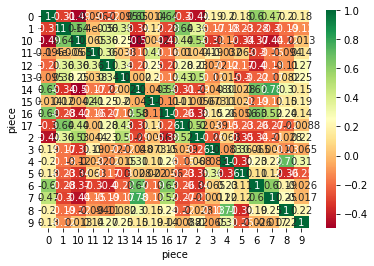

In [11]:
lvl_data_csv = data_organizer(scanMan, 'level', set_mod=False)['level']
sns.heatmap(lvl_data_csv.corr(), annot=True, cbar=True, cmap="RdYlGn")

<AxesSubplot:xlabel='piece', ylabel='piece'>

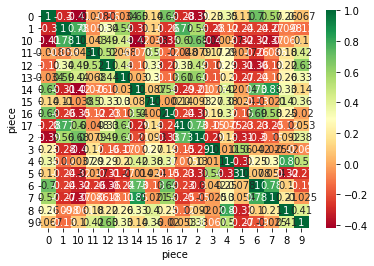

In [12]:
freq_data_csv = data_organizer(scanMan, 'frequency', set_mod=False)['frequency']
sns.heatmap(freq_data_csv.corr(), annot=True, cbar=True, cmap="RdYlGn")

## Creation de modeles

In [13]:
# Separation des donnees
def data_separator(model_data_csv):
    # Shuffle  les lignes
    model_data_csv = model_data_csv.sample(frac=1)
    #model_data_csv.reindex(np.random.permutation(model_data_csv.index))
    
    x1, y1, x2, y2 = [], [], [], []
    x_train2, x_test2, y_train2, y_test2 = [], [], [], []
    for piece in model_data_csv:
        room_name = int(piece.split(':')[0])
        # On met de cote dans x1, y1 1 donnee de chaque piece
        if room_name not in y1 :
            y1.append(room_name)
            x1.append(model_data_csv[piece])
        else:
            y2.append(room_name)
            x2.append(model_data_csv[piece])
    
    
    # On split aleatoirement en test et entrainement les data des salles
    x_train2, x_test2, y_train2, y_test2 = train_test_split(x2,
                                                    y2,
                                                    test_size=0.2,
                                                    random_state=42)
    
    
        
    return x_train2+x1, x_test2, y_train2+y1, y_test2

In [14]:
# Creation d'un modèle KNeighborsClassifier
def create_KNeighborsClassifier(x_train, x_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(x_train, y_train)
    return model

# Creation d'un modèle RandomForestClassifier
def create_RandomForestClassifier(x_train, x_test, y_train, y_test):
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    return model

In [15]:
# Mesure de l'efficacite du modele

def get_efficiency(model):
    somme = 0
    nb = 20

    for i in range(nb):
        somme += model.score(x_test, y_test)

    precision = "{:.2f}".format(somme / nb)
    print("Précisions sur " + str(nb) + " essais pour le modèle = " + str(precision))
    return precision

In [16]:
def get_predict(dico, scanMan) :
    x = [0]*len(scanMan.BSSIDOrder)
    for wifi in dico_sent_test:
        wifi = dico_sent_test[wifi]
        bssid = wifi["BSSID"]
        if bssid in scanMan.BSSIDOrder:
            bssid = scanMan.BSSIDOrder[bssid]
            x[bssid] = wifi["level"]

    prediction = scanMan.pieceInverse[model.predict([x])[0]]
    predict_proba = model.predict_proba([x])
    return prediction, predict_proba
    

In [17]:
def organize_dico_for_pred(dico_sent, scanMan):
    dico = {}
    dico["BSSID"] = []
    # dico["capabilities"] = []
    dico["centerFreq0"] = []
    dico["centerFreq1"] = []
    dico["channelWidth"] = []
    dico["frequency"] = []
    dico["level"] = []
    dico["operatorFriendlyName"] = []
    dico["SSID"] = []
    dico["timestamp"] = []
    
    
    for wifi in dico_sent :
        wifi = dico_sent[wifi]
        dico["BSSID"].append(scanMan.BSSIDOrder[wifi["BSSID"]])
        # dico["capabilities"].append(wifi.capabilities)
        dico["centerFreq0"].append(int(wifi["centerFreq0"]))
        dico["centerFreq1"].append(int(wifi["centerFreq1"]))
        dico["channelWidth"].append(int(wifi["channelWidth"]))
        dico["frequency"].append(int(wifi["frequency"]))
        dico["level"].append(int(wifi["level"]))
        dico["operatorFriendlyName"].append(wifi["operatorFriendlyName"])
        dico["SSID"].append(wifi["SSID"])
        dico["timestamp"].append(int(wifi["timestamp"]))
        # dico["venueName"].append(wifi.venueName)
    
    data_csv = pd.DataFrame.from_dict(dico)
    data_csv = all_data_csv[ ['BSSID', 'level'] ]
    print("tentative get x for pred : ", data_csv)
    return data_csv


In [18]:
def get_dico_test():
    return {'wifi0': {'BSSID': '1c:28:af:ce:e7:00', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2437, 'level': -40, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi1': {'BSSID': '1c:28:af:ce:e7:01', 'capabilities': '[WPA2-EAP+FT/EAP-CCMP][WPA-EAP-TKIP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2437, 'level': -40, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'UnivToulon', 'venueName': ''}, 'wifi2': {'BSSID': '1c:28:af:ce:e7:02', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2437, 'level': -41, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi3': {'BSSID': '1c:28:af:ce:e7:11', 'capabilities': '[WPA2-EAP+FT/EAP-CCMP][WPA-EAP-TKIP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5785, 'level': -70, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'UnivToulon', 'venueName': ''}, 'wifi4': {'BSSID': '1c:28:af:ce:e7:10', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5785, 'level': -71, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi5': {'BSSID': '1c:28:af:ce:e7:12', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5785, 'level': -71, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi6': {'BSSID': '1c:28:af:ce:1b:c0', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2412, 'level': -78, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi7': {'BSSID': '1c:28:af:ce:1b:c1', 'capabilities': '[WPA2-EAP+FT/EAP-CCMP][WPA-EAP-TKIP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2412, 'level': -78, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'UnivToulon', 'venueName': ''}, 'wifi8': {'BSSID': '1c:28:af:ce:1b:c2', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2412, 'level': -78, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi9': {'BSSID': '1c:28:af:b4:1c:e2', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2462, 'level': -82, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi10': {'BSSID': 'bc:9f:e4:8b:52:a0', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2412, 'level': -82, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi11': {'BSSID': '1c:28:af:b4:1c:e1', 'capabilities': '[WPA2-EAP+FT/EAP-CCMP][WPA-EAP-TKIP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2462, 'level': -83, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'UnivToulon', 'venueName': ''}, 'wifi12': {'BSSID': '1c:28:af:b4:1c:e0', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2462, 'level': -83, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi13': {'BSSID': '1c:28:af:b2:c8:42', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2462, 'level': -85, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi14': {'BSSID': '1c:28:af:b2:c8:40', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2462, 'level': -85, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi15': {'BSSID': '1c:28:af:b2:97:e2', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 2437, 'level': -88, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}, 'wifi16': {'BSSID': '1c:28:af:b2:c8:51', 'capabilities': '[WPA2-EAP+FT/EAP-CCMP][WPA-EAP-TKIP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5280, 'level': -92, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'UnivToulon', 'venueName': ''}, 'wifi17': {'BSSID': '1c:28:af:b2:c8:50', 'capabilities': '[WPA2-EAP-CCMP][WPA-EAP-TKIP+CCMP][ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5280, 'level': -93, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'eduroam', 'venueName': ''}, 'wifi18': {'BSSID': '1c:28:af:b2:c8:52', 'capabilities': '[ESS]', 'centerFreq0': 0, 'centerFreq1': 0, 'channelWidth': 0, 'frequency': 5280, 'level': -93, 'timestamp': 1434210693756, 'operatorFriendlyName': '', 'SSID': 'visiteurs', 'venueName': ''}}

In [19]:
#model_data_csv = get_data_csv(scanMan)[['piece', 'level', 'frequency', 'BSSID']]
model_data_csv = data_organizer(scanMan)['level']
#print(model_data_csv)
x_train, x_test, y_train, y_test = data_separator(model_data_csv)
print(x_train[0], type(x_train[0]))
len(x_train), len(x_test), len(y_train), len(y_test)

BSSID
171     0
5       0
199     0
166     0
57      0
       ..
98    -97
3       0
193     0
195     0
74      0
Name: 10:1, Length: 211, dtype: int64 <class 'pandas.core.series.Series'>


(114, 25, 114, 25)

### Test des modeles

In [20]:
model = create_KNeighborsClassifier(x_train, x_test, y_train, y_test)
efficiency = get_efficiency(model)

Précisions sur 20 essais pour le modèle = 0.68


In [21]:
model = create_RandomForestClassifier(x_train, x_test, y_train, y_test)
efficiency = get_efficiency(model)

Précisions sur 20 essais pour le modèle = 0.76


#### Etude des resultats

In [22]:
dico_sent_test = get_dico_test()

res = get_predict(dico_sent_test, scanMan)
print(res[0])
print(res[1])

U-220
[[0.12 0.02 0.07 0.02 0.07 0.05 0.03 0.09 0.   0.03 0.17 0.01 0.04 0.01
  0.05 0.03 0.19 0.  ]]


#### Matrice de Confusion

Text(24.0, 0.5, 'y_true')

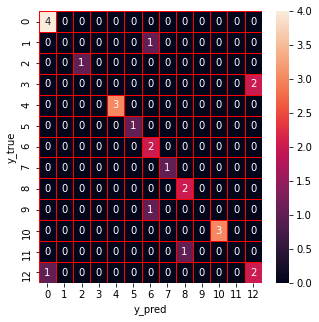

In [23]:
y_pred = model.predict(x_test)
y_true = y_test

conf_mat = confusion_matrix(y_true, y_pred)

f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(conf_mat, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")

In [24]:
scanMan.pieceInverse

{0: 'U-211',
 1: 'U-004',
 2: 'U-Foyer',
 3: 'U-Couloir-Etage2',
 4: 'U-113',
 5: 'U-Couloir-Etage3',
 6: 'U-218',
 7: 'U-214',
 8: 'U-118',
 9: 'U-108',
 10: 'U-001',
 11: 'U-100',
 12: 'U-104',
 13: 'U-Administration',
 14: 'U-207',
 15: 'U-Couloir-Etage1',
 16: 'U-220',
 17: 'U-Couloir-001-004'}